## Importing Required Libraries  

In [31]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split

In [32]:
# Set image dimensions
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 32
EPOCHS = 50

# Path to dataset
IMAGE_DIR = "dataset/image"
MASK_DIR = "dataset/mask"


In [33]:
# Load images and masks
def load_data(image_dir, mask_dir, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))  # Ensure correct order
    mask_files = sorted(os.listdir(mask_dir))

    count = 0

    for img_file, mask_file in zip(image_files, mask_files):
        if(count>=1000):
            break
        # Read and resize images
        img = cv2.imread(os.path.join(image_dir, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, img_size) / 255.0  # Normalize

        # Read and resize masks
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        mask = mask / 255.0  # Convert to binary (0 or 1)

        images.append(img)
        masks.append(mask)
        count+=1
    return np.array(images), np.array(masks)

# Load dataset
X, Y = load_data(IMAGE_DIR, MASK_DIR)
print(f"Dataset loaded: {X.shape}, {Y.shape}")

Dataset loaded: (1000, 128, 128, 3), (1000, 128, 128, 1)


In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

### U-Net Model for Image Segmentation  

This code defines and trains a U-Net model using TensorFlow and Keras for image segmentation.  

#### **Key Components**  
- **U-Net Architecture**: A deep learning model with an encoder-decoder structure for pixel-wise classification.  
- **Batch Normalization & Dropout**: Used to stabilize training and prevent overfitting.  
- **Custom Metrics**: Includes IoU (Intersection over Union) and Dice coefficient for segmentation evaluation.  
- **Loss Function**: A combination of Dice loss and Binary Cross-Entropy for better optimization.  
- **Training & Saving**: The model is trained on a dataset and saved for future use.

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Hyperparameters
START_FILTERS = 64  # Starting number of filters, all others are multiples of this
DROPOUT_RATE = 0.3  # Dropout rate to reduce overfitting
LEARNING_RATE = 1e-3  # Lower learning rate for stable convergence
BATCH_SIZE = 16
EPOCHS = 50

def unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), start_filters=START_FILTERS, dropout_rate=DROPOUT_RATE):
    inputs = Input(input_shape)

    # Encoder
    f = start_filters  # Base filter size
    c1 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(dropout_rate)(c1)
    c1 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    f *= 2
    c2 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(dropout_rate)(c2)
    c2 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    f *= 2
    c3 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(dropout_rate)(c3)
    c3 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    f *= 2
    c4 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(dropout_rate)(c4)
    c4 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    f *= 2
    c5 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(dropout_rate)(c5)
    c5 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Decoder
    f //= 2
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(dropout_rate)(c6)
    c6 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    f //= 2
    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(dropout_rate)(c7)
    c7 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    f //= 2
    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(dropout_rate)(c8)
    c8 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    f //= 2
    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(dropout_rate)(c9)
    c9 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

# Metrics
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-7)

def dice_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)

# Compile Model
model = unet()
def dice_loss(y_true, y_pred, smooth=1e-6):
    # Do not threshold y_pred; use it as is for gradient flow.
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice_coef = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice_coef


def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss=dice_loss, metrics=[iou_metric, dice_metric])

# Train Model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

# Save Model
model.save("final-128.h5")


Epoch 1/50
50/50 [==============================] - 9s 163ms/step - loss: 0.3166 - iou_metric: 0.5326 - dice_metric: 0.6884 - val_loss: 0.5001 - val_iou_metric: 0.3325 - val_dice_metric: 0.4987
Epoch 2/50
50/50 [==============================] - 8s 159ms/step - loss: 0.1995 - iou_metric: 0.6706 - dice_metric: 0.8023 - val_loss: 0.5005 - val_iou_metric: 0.3322 - val_dice_metric: 0.4983
Epoch 3/50
50/50 [==============================] - 8s 160ms/step - loss: 0.1775 - iou_metric: 0.7010 - dice_metric: 0.8236 - val_loss: 0.4348 - val_iou_metric: 0.3932 - val_dice_metric: 0.5638
Epoch 4/50
50/50 [==============================] - 8s 160ms/step - loss: 0.1648 - iou_metric: 0.7190 - dice_metric: 0.8360 - val_loss: 0.2238 - val_iou_metric: 0.6344 - val_dice_metric: 0.7760
Epoch 5/50
50/50 [==============================] - 8s 161ms/step - loss: 0.1514 - iou_metric: 0.7387 - dice_metric: 0.8492 - val_loss: 0.2809 - val_iou_metric: 0.5636 - val_dice_metric: 0.7202
Epoch 6/50
50/50 [============

In [6]:
# model=tf.keras.models.load_model("ak.h5",custom_objects={'iou_metric':iou_metric,'dice_metric':dice_metric})

### Post-Processing U-Net Predictions  

This function applies morphological closing and Gaussian smoothing to refine U-Net segmentation masks. The processing includes:  

1. **Thresholding:** Converts predictions into binary masks.  
2. **Morphological Closing:** Fills small holes using a kernel-based operation.  
3. **Gaussian Blur:** Smoothens edges for better visual appearance.  

The function handles both batch and single-image inputs, ensuring the output maintains the original shape.

In [54]:
import cv2
import numpy as np

def post_process_mask(preds, kernel_size=7, blur_size=3):
    """
    Post-process U-Net predictions using morphological closing and Gaussian smoothing.
    
    Args:
    - preds: Predicted masks (batch or single image).
    - kernel_size: Size of the kernel for morphological closing.
    - blur_size: Kernel size for Gaussian blur.
    
    Returns:
    - Smoothed mask(s) in the same shape as input.
    """
    # Handle single image case by expanding dimensions
    is_single = False
    if preds.ndim == 3:  # Single image with (H, W, 1) shape
        preds = np.expand_dims(preds, axis=0)
        is_single = True

    processed_preds = []

    for i in range(preds.shape[0]):
        # Threshold the mask to binary (0 or 1)
        mask = (preds[i, :, :, 0] > 0.5).astype(np.uint8)

        # Morphological closing
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # Gaussian blur for smooth edges
        blurred_mask = cv2.GaussianBlur(closed_mask.astype(np.float32), (blur_size, blur_size), 0)

        # Normalize back to 0-1 range
        blurred_mask = np.clip(blurred_mask, 0, 1)

        processed_preds.append(blurred_mask)

    # Convert back to batch or single image format
    result = np.array(processed_preds)

    if is_single:
        return result[0]  # Return the single image mask
    return result  # Return batch masks


### IoU and Dice Score Calculation  

This script evaluates segmentation model performance using **Intersection over Union (IoU)** and **Dice coefficient**. These metrics measure how well predicted masks match ground truth masks.  

#### **1. IoU Calculation (`calculate_iou`)**  
- Converts masks to binary.  
- Computes **intersection** (overlapping pixels).  
- Computes **union** (total pixels in both masks).  
- Returns IoU as `intersection / union`, handling edge cases.  

#### **2. Dice Score Calculation (`calculate_dice`)**  
- Similar to IoU, but uses the **Dice formula**:  
- Handles edge cases where both masks are empty.  

#### **3. Model Evaluation**  
- Predicts masks on validation set (`model.predict(X)`).  
- Computes IoU and Dice for each image.  
- Calculates **mean IoU** and **mean Dice** across the dataset.

In [56]:
import numpy as np


def calculate_iou(y_true, y_pred, threshold=0.5):
    # Ensure inputs are binary
    if y_true.dtype != np.bool_:
        y_true = y_true.astype(bool)

    if y_pred.dtype != np.bool_:
        y_pred = (y_pred > threshold).astype(bool)

    # Calculate intersection and union
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()

    # Handle edge case of empty masks
    if union == 0:
        return 1.0  # Both masks are empty, perfect match

    return intersection / union

def calculate_dice(y_true, y_pred, threshold=0.5):
    # Ensure inputs are binary
    if y_true.dtype != np.bool_:
        y_true = y_true.astype(bool)

    if y_pred.dtype != np.bool_:
        y_pred = (y_pred > threshold).astype(bool)

    # Calculate dice coefficient: 2*|X∩Y|/(|X|+|Y|)
    intersection = np.logical_and(y_true, y_pred).sum()
    total = y_true.sum() + y_pred.sum()

    # Handle edge case of empty masks
    if total == 0:
        return 1.0  # Both masks are empty, perfect match

    return 2 * intersection / total

# Predict on validation set
y_preds = model.predict(X)
# Compute IoU for each image
iou_scores = []
dice_scores = []
for i in range(len(Y)):
    iou = calculate_iou(Y[i], y_preds[i])
    dice = calculate_dice(Y[i], y_preds[i])
    iou_scores.append(iou)
    dice_scores.append(dice)
    print(f"Image {i+1}: IoU = {iou:.4f}")
    print(f"Image {i+1}: Dice = {dice:.4f}")

# Compute Mean IoU
mean_iou = np.mean(iou_scores)
mean_dice = np.mean(dice_scores)
print(f"\nMean IoU on Validation Set: {mean_iou:.4f}")
print(f"\nMean Dice on Validation Set: {mean_dice:.4f}")

32/32 [==============================] - 3s 81ms/step
Image 1: IoU = 0.9520
Image 1: Dice = 0.9754
Image 2: IoU = 0.6576
Image 2: Dice = 0.7934
Image 3: IoU = 0.8599
Image 3: Dice = 0.9247
Image 4: IoU = 0.9196
Image 4: Dice = 0.9581
Image 5: IoU = 0.5713
Image 5: Dice = 0.7271
Image 6: IoU = 0.7195
Image 6: Dice = 0.8369
Image 7: IoU = 0.7273
Image 7: Dice = 0.8421
Image 8: IoU = 0.7034
Image 8: Dice = 0.8259
Image 9: IoU = 0.8747
Image 9: Dice = 0.9332
Image 10: IoU = 0.7219
Image 10: Dice = 0.8385
Image 11: IoU = 0.8951
Image 11: Dice = 0.9447
Image 12: IoU = 0.8335
Image 12: Dice = 0.9092
Image 13: IoU = 0.7150
Image 13: Dice = 0.8338
Image 14: IoU = 0.4071
Image 14: Dice = 0.5786
Image 15: IoU = 0.3633
Image 15: Dice = 0.5330
Image 16: IoU = 0.3096
Image 16: Dice = 0.4728
Image 17: IoU = 0.4346
Image 17: Dice = 0.6059
Image 18: IoU = 0.5624
Image 18: Dice = 0.7199
Image 19: IoU = 0.4413
Image 19: Dice = 0.6123
Image 20: IoU = 0.8703
Image 20: Dice = 0.9307
Image 21: IoU = 0.7975
I

### **IoU and Dice Score Evaluation for Segmentation Models**  

This script calculates two key performance metrics—**Intersection over Union (IoU)** and **Dice Coefficient**—for segmentation models. It evaluates how well the predicted masks align with ground truth labels.


In [57]:
import numpy as np


def calculate_iou(y_true, y_pred, threshold=0.5):
    # Ensure inputs are binary
    if y_true.dtype != np.bool_:
        y_true = y_true.astype(bool)

    if y_pred.dtype != np.bool_:
        y_pred = (y_pred > threshold).astype(bool)

    # Calculate intersection and union
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()

    # Handle edge case of empty masks
    if union == 0:
        return 1.0  # Both masks are empty, perfect match

    return intersection / union

def calculate_dice(y_true, y_pred, threshold=0.5):
    # Ensure inputs are binary
    if y_true.dtype != np.bool_:
        y_true = y_true.astype(bool)

    if y_pred.dtype != np.bool_:
        y_pred = (y_pred > threshold).astype(bool)

    # Calculate dice coefficient: 2*|X∩Y|/(|X|+|Y_val|)
    intersection = np.logical_and(y_true, y_pred).sum()
    total = y_true.sum() + y_pred.sum()

    # Handle edge case of empty masks
    if total == 0:
        return 1.0  # Both masks are empty, perfect match

    return 2 * intersection / total

# Predict on validation set
y_preds = model.predict(X_val)
# Compute IoU for each image
iou_scores = []
dice_scores = []
for i in range(len(Y_val)):
    iou = calculate_iou(Y_val[i], y_preds[i])
    dice = calculate_dice(Y_val[i], y_preds[i])
    iou_scores.append(iou)
    dice_scores.append(dice)
    print(f"Image {i+1}: IoU = {iou:.4f}")
    print(f"Image {i+1}: Dice = {dice:.4f}")

# Compute Mean IoU
mean_iou = np.mean(iou_scores)
mean_dice = np.mean(dice_scores)
print(f"\nMean IoU on Validation Set: {mean_iou:.4f}")
print(f"\nMean Dice on Validation Set: {mean_dice:.4f}")

7/7 [==============================] - 1s 121ms/step
Image 1: IoU = 0.8568
Image 1: Dice = 0.9229
Image 2: IoU = 0.8991
Image 2: Dice = 0.9469
Image 3: IoU = 0.9320
Image 3: Dice = 0.9648
Image 4: IoU = 0.8504
Image 4: Dice = 0.9191
Image 5: IoU = 0.7755
Image 5: Dice = 0.8735
Image 6: IoU = 0.8446
Image 6: Dice = 0.9157
Image 7: IoU = 0.9062
Image 7: Dice = 0.9508
Image 8: IoU = 0.9012
Image 8: Dice = 0.9480
Image 9: IoU = 0.7723
Image 9: Dice = 0.8715
Image 10: IoU = 0.7989
Image 10: Dice = 0.8882
Image 11: IoU = 0.6781
Image 11: Dice = 0.8082
Image 12: IoU = 0.9297
Image 12: Dice = 0.9636
Image 13: IoU = 0.7970
Image 13: Dice = 0.8871
Image 14: IoU = 0.6286
Image 14: Dice = 0.7720
Image 15: IoU = 0.6011
Image 15: Dice = 0.7508
Image 16: IoU = 0.7157
Image 16: Dice = 0.8343
Image 17: IoU = 0.7383
Image 17: Dice = 0.8495
Image 18: IoU = 0.3622
Image 18: Dice = 0.5318
Image 19: IoU = 0.8016
Image 19: Dice = 0.8899
Image 20: IoU = 0.8713
Image 20: Dice = 0.9312
Image 21: IoU = 0.8815
Im

### **Model Prediction Visualization for Segmentation**  

This function visualizes a **sample prediction** from a trained segmentation model, comparing it with the original image and ground truth mask.

---

### **1. Predicting the Segmentation Mask (`predict_sample`)**  
- Selects an image from the validation set (`X_val[index]`).
- Uses the model to generate a predicted segmentation mask.
- **Applies thresholding** (`> 0.5`) to convert probabilities into a binary mask.
- **Post-processes** the mask using `post_process_mask()` (e.g., smoothing, morphological operations).

---

### **2. Visualizing Results**  
- **First subplot**: Displays the **original image**.  
- **Second subplot**: Displays the **ground truth mask**.  
- **Third subplot**: Displays the **predicted mask** after post-processing.  

The function uses **Matplotlib** to create a side-by-side comparison of the original image, actual segmentation mask, and predicted mask.

---

### **3. Running the Function**  
- Calls `predict_sample(model, X_val, Y_val)`, using a default index of **55**.
- Allows manual selection of specific images for debugging and evaluation.

This visualization helps assess model performance and identify cases where predictions may need improvement.

1/1 [==============================] - 0s 15ms/step


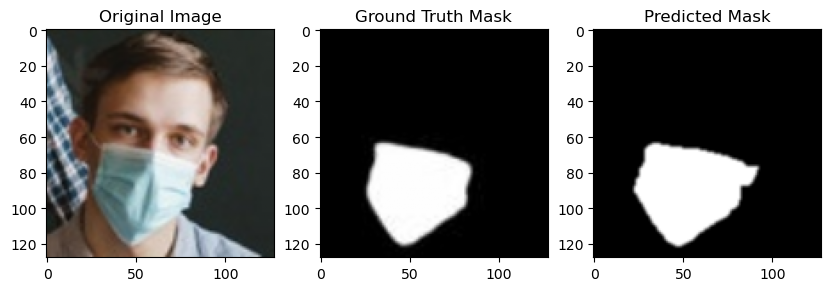

In [58]:
# Evaluate Model
def predict_sample(model, X_val, Y_val, index=55):
    pred_mask = model.predict(np.expand_dims(X_val[index], axis=0))[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Thresholding
    pred_mask = post_process_mask(pred_mask)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[index])
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(Y_val[index].squeeze(), cmap="gray")
    plt.title("Ground Truth Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.squeeze(), cmap="gray")
    plt.title("Predicted Mask")
    plt.show()

# Test model on a sample image
predict_sample(model, X_val, Y_val)

### **Updated IoU and Dice Score Calculation Functions**  

This updated implementation ensures **correct shape handling**, **thresholding**, and **numerical stability** while calculating **IoU (Intersection over Union) and Dice coefficient** for segmentation tasks.

---

### **1. Shape Handling (`ensure_same_shape`)**
- **Removes unnecessary dimensions** if the shape is `(H, W, 1)`, converting it to `(H, W)`.
- **Ensures `y_true` and `y_pred` have the same shape** before computation.
- **Raises an error** if the shapes remain mismatched.

---

### **2. IoU Calculation (`calculate_iou`)**
- Converts inputs into **binary masks** using a **threshold**.
- Computes **intersection** (`sum of common foreground pixels`).
- Computes **union** (`sum of both masks minus the intersection`).
- **Prevents division by zero** by setting `union = max(union, 1e-7)`.
- Returns the **IoU score** (`intersection / union`).

---

### **3. Dice Score Calculation (`calculate_dice`)**
- Converts inputs into **binary masks** using a **threshold**.
- Computes **intersection** (`sum of common foreground pixels`).
- Computes **sum of both masks** as `union = sum(y_true) + sum(y_pred)`.
- **Prevents division by zero** (`max(union, 1e-7)`).
- Returns the **Dice coefficient** (`2 * intersection / union`).

In [59]:
import numpy as np

def ensure_same_shape(y_true, y_pred):
    """
    Ensure that y_true and y_pred have the same shape.
    - If one has an extra dimension, squeeze it.
    - If dimensions are mismatched, raise an error.
    """
    if y_true.ndim == 3 and y_true.shape[-1] == 1:
        y_true = np.squeeze(y_true, axis=-1)  # (128, 128, 1) → (128, 128)
    
    if y_pred.ndim == 3 and y_pred.shape[-1] == 1:
        y_pred = np.squeeze(y_pred, axis=-1)

    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch after squeeze: y_true={y_true.shape}, y_pred={y_pred.shape}")

    return y_true, y_pred


def calculate_iou(y_true, y_pred, threshold=0.5):
    """
    Calculate Intersection over Union (IoU).
    """
    # Ensure consistent shapes
    y_true, y_pred = ensure_same_shape(y_true, y_pred)

    # Convert to binary masks
    y_true = (y_true > 0.5).astype(np.float32)
    y_pred = (y_pred > threshold).astype(np.float32)

    # Calculate intersection and union
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection

    # Prevent division by zero
    intersection = max(intersection, 0)
    union = max(union, 1e-7)

    iou = intersection / union
    return iou


def calculate_dice(y_true, y_pred, threshold=0.5):
    """
    Calculate Dice coefficient.
    """
    # Ensure consistent shapes
    y_true, y_pred = ensure_same_shape(y_true, y_pred)

    # Convert to binary masks
    y_true = (y_true > 0.5).astype(np.float32)
    y_pred = (y_pred > threshold).astype(np.float32)

    # Calculate intersection and union
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)

    # Prevent division by zero
    intersection = max(intersection, 0)
    union = max(union, 1e-7)

    dice = (2.0 * intersection) / union
    return dice


### **Batch-Wise IoU and Dice Score Computation for Segmentation Models**

This code processes a batch of predictions, applies post-processing, and evaluates segmentation quality using **IoU (Intersection over Union) and Dice coefficient**.  

In [60]:
# Predict on batch
y_preds = model.predict(X_val)

# Apply post-processing
smoothed_preds = post_process_mask(y_preds)

# Calculate IoU and Dice scores for the batch
iou_scores = []
dice_scores = []

for i in range(len(Y_val)):
    iou = calculate_iou(Y_val[i], smoothed_preds[i])
    dice = calculate_dice(Y_val[i], smoothed_preds[i])
    
    iou_scores.append(iou)
    dice_scores.append(dice)

# Display Average IoU and Dice
avg_iou = np.mean(iou_scores)
avg_dice = np.mean(dice_scores)

print(f"Average IoU: {avg_iou:.4f}")
print(f"Average Dice: {avg_dice:.4f}")


7/7 [==============================] - 1s 110ms/step
Average IoU: 0.8355
Average Dice: 0.9026
